### Устанавливаем необходимые зависимости

В их числе:

* gym –  комплект инструментов с  открытым исходным кодом, предназначенный для разработки и сравнения алгоритмов RL. Он
предлагает интерфейс к  различным имитационным моделям и  задачам RL. Полный список окружающих сред см. по адресу https://www.gymlibrary.ml/


In [1]:
!pip install gym[all]
!pip install pyvirtualdisplay 
!pip install xvfbwrapper
!pip install torch
!pip install box2d-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-regl4ca8/mujoco-py_52db678dcffb4c97a80313179e649869/setup.py'"'"'; __file__='"'"'/tmp/pip-install-regl4ca8/mujoco-py_52db678dcffb4c97a80313179e649869/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-89zy8q0u/install-record.txt --single-version-externally-managed --compile --instal

Дополнительные пакеты для linux

In [2]:
!apt-get install ffmpeg
!apt-get install python-opengl -y
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.


In [3]:
import gym
import numpy as np
from pyvirtualdisplay import Display
from tqdm import tqdm
import os
import shutil
import torch
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Создаем виртуальный экран, чтобы затем сохранять видео
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# Создаем игровое окружение игры LunarLander
env = gym.make('LunarLander-v2')

# Создаем папку для записи видео и указываем виртуальной среде его как путь
# для записи видео с виртуального экрана

video_dir = './video_test/'
if os.path.exists(video_dir):
    shutil.rmtree(video_dir)
env = gym.wrappers.Monitor(env, video_dir)

# Функция принимающая на вход состояние среды и возвращающая случайное действие
def predict_action(state):
    global env
    return env.action_space.sample()

state = env.reset()
is_done = False
while not is_done:
        action = predict_action(state)
        state, reward, is_done, _ = env.step(action)
env.close()

# В итоге в папке 'video_test' будет лежать видеозапись с тем как 
# наша функция – агент predict_action играет в игру LunarLander

In [6]:
# Функция для тестирования функции Актора
def test_actor(actor_function, n_episode=1000):
    env = gym.make('LunarLander-v2')

    env = gym.wrappers.Monitor(env, video_dir, force=True)

    episode_rewards = []

    for episode in tqdm(range(n_episode)):
        state = env.reset()
        is_done = False
        total_reward = 0
        while not is_done:
            action = actor_function(state)
            state, reward, is_done, _ = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)

    env.close()
    # Выводим наш скор по результатам тестирования
    print(f'\nСредняя награда по результатам {n_episode} эпизодов: {sum(episode_rewards)/n_episode}')
    return sum(episode_rewards)/n_episode

In [7]:
test_actor(predict_action)

100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s]


Средняя награда по результатам 1000 эпизодов: -179.1376410907998


-179.1376410907998

In [8]:
# Попробуем найти лучшее решение путем случайного подбора матрицы весов

env = gym.make('LunarLander-v2')
n_episode = 1000
best_total_reward = 0
best_weight = None
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
print((n_state, n_action))

for episode in tqdm(range(n_episode)):
     state = env.reset()
     total_reward = 0
     is_done = False
     weight = torch.rand(n_state, n_action) # Генерируем случайную матрицу размерности (8, 4)
     while not is_done:
         state = torch.from_numpy(state).float()
         action = torch.argmax(torch.matmul(state, weight)) # Выбираем более вероятное действие
         state, reward, is_done, _ = env.step(action.item())
         total_reward += reward
     if total_reward > best_total_reward:
         best_weight = weight
         best_total_reward = total_reward

(8, 4)


100%|██████████| 1000/1000 [00:28<00:00, 34.55it/s]


In [10]:
BEST_WEIGHT = best_weight

# Создаем функцию Актора с использованием лучших весов
def predict_action_2(state):
    global BEST_WEIGHT
    state = torch.from_numpy(state).float()
    action = torch.argmax(torch.matmul(state, BEST_WEIGHT))
    return action.item()

In [11]:
# Тестируем
test_actor(predict_action_2, n_episode=1000)

100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s]


Средняя награда по результатам 1000 эпизодов: -186.53003852603135


-186.53003852603135

In [12]:
# Отсюда ваше обучение

class PolicyGradient:   
    # Инициализиция всех необходимых переменных
    def __init__(self, n_x, n_y, learning_rate=0.01, reward_decay=0.95):
            
        # Кол-во состояний в среде    
        self.n_x = n_x 
        
        # Кол-во действий в среде
        self.n_y = n_y
        
        # Скорость обучения сети
        self.lr = learning_rate
        
        # Коэффициент поправки
        self.gamma = reward_decay 
    
        # Инициализация списков для хранения наблюдений, действий и наград
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        
        # Определение функции для построения нейронной сети
        self.build_network()
        
        # Сохранение потерь
        self.cost_history = []
        
        # Инициализация сессии 
        self.sess = tf.compat.v1.Session()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def copy(self):
      return PolicyGradient()
        
    # Функция для хранения переходов, то есть состояния, действия и награды
    def store_transition(self, s, a, r):
        self.episode_observations.append(s)
        self.episode_rewards.append(r)

        # Сохранение действия в виде списка массивов
        action = np.zeros(self.n_y)
        action[a] = 1
        self.episode_actions.append(action)
        
    # Функция для выбора действия по заданному состоянию
    def choose_action(self, observation):
        # Изменение размера состояния
        observation = observation[:, np.newaxis]

        # Прямое распространение для получения вероятностей
        prob_weights = self.sess.run(self.outputs_softmax, feed_dict = {self.X: observation})

        # Выбрать действие с использование смещенной выборки; возвращается индекс действия
        action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
        
        return action

    # Функция для построения нейронной сети
    def build_network(self):
        
        # Переменные для ввода x и вывода y
        self.X = tf.compat.v1.placeholder(tf.float32, shape=(self.n_x, None), name="X")
        self.Y = tf.compat.v1.placeholder(tf.float32, shape=(self.n_y, None), name="Y")
        
        # Переменная для награды
        self.discounted_episode_rewards_norm = tf.compat.v1.placeholder(tf.float32, [None, ], name="actions_value")

        # Кол-во нейронов в скрытых слоях
        units_layer_1 = 20
        units_layer_2 = 20
        
        # Кол-во нейронов в выходном слое
        units_output_layer = self.n_y
        
        #  Инициализация веса и смещение с использованием метода glorot_normal, который эквивалентен иниициализации Ксавье
        W1 = tf.compat.v1.get_variable("W1", [units_layer_1, self.n_x], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))
        b1 = tf.compat.v1.get_variable("b1", [units_layer_1, 1], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))
        W2 = tf.compat.v1.get_variable("W2", [units_layer_2, units_layer_1], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))
        b2 = tf.compat.v1.get_variable("b2", [units_layer_2, 1], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))
        W3 = tf.compat.v1.get_variable("W3", [self.n_y, units_layer_2], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))
        b3 = tf.compat.v1.get_variable("b3", [self.n_y, 1], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed=1))

        # Проход вперед по сети
        Z1 = tf.add(tf.matmul(W1,self.X), b1)
        A1 = tf.nn.relu(Z1)
        Z2 = tf.add(tf.matmul(W2, A1), b2)
        A2 = tf.nn.relu(Z2)
        Z3 = tf.add(tf.matmul(W3, A2), b3)
        A3 = tf.nn.softmax(Z3)

        # Применение софтмакс для получения вероятней на выходном слое
        logits = tf.transpose(Z3)
        labels = tf.transpose(self.Y)
        self.outputs_softmax = tf.nn.softmax(logits, name='A3')

        # После расчитываем фукнцию потерь
        neg_log_prob = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        
        # Расчет награды исходя из потерь
        loss = tf.reduce_mean(neg_log_prob * self.discounted_episode_rewards_norm)  

        # Инициализация оптимизатора Adam
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss)

    # Функция для расчета скоректированной награды
    def discount_and_norm_rewards(self):
        discounted_episode_rewards = np.zeros_like(self.episode_rewards)
        cumulative = 0
        for t in reversed(range(len(self.episode_rewards))):
            cumulative = cumulative * self.gamma + self.episode_rewards[t]
            discounted_episode_rewards[t] = cumulative

        discounted_episode_rewards -= np.mean(discounted_episode_rewards)
        discounted_episode_rewards /= np.std(discounted_episode_rewards)
        return discounted_episode_rewards
    
    # Функция обучения
    def fit(self):
        # Расчет награды эпизода
        discounted_episode_rewards_norm = self.discount_and_norm_rewards()

        # Обучение сети
        self.sess.run(self.train_op, feed_dict={
             self.X: np.vstack(self.episode_observations).T,
             self.Y: np.vstack(np.array(self.episode_actions)).T,
             self.discounted_episode_rewards_norm: discounted_episode_rewards_norm,
        })

        # Сброс данных эпизода
        self.episode_observations, self.episode_actions, self.episode_rewards  = [], [], []

        return discounted_episode_rewards_norm

In [13]:
RENDER_ENV = False
EPISODES = 10000
rewards = []
RENDER_REWARD_MIN = 500

PG = PolicyGradient(
    n_x = env.observation_space.shape[0],
    n_y = env.action_space.n,
    learning_rate=0.02,
    reward_decay=0.99,
)

exit = False
best_actor = None
best_reward = -np.inf
for episode in range(EPISODES):
  
  # Получение состояния
  observation = env.reset()
  episode_reward = 0

  while True:
      if RENDER_ENV: 
        env.render()

      # Выбор действия на основе полученного состояния
      action = PG.choose_action(observation)

      # Выполнение действия, переход к следующему состоянию и получение награды
      observation_, reward, done, info = env.step(action)

      # Сохранение информации 
      PG.store_transition(observation, action, reward)
      
      # Суммирование награды, полученной в каждом эпизоде
      episode_rewards_sum = sum(PG.episode_rewards)
  
      # Если награда больше 250, то прекратить обучение
      # После наблюдения за обучением актора понял, что при данном методе обучения
      # у актора награды за эпизоды в среднем не превышают 280, далее начинает деградировать
      if episode_rewards_sum > 250:
          exit = True
          print("Episode: ", episode)
          print("Reward: ", episode_rewards_sum)
          break
      else:
        exit = False

      if episode_rewards_sum < -250:
        done = True
      
      if done:
          episode_rewards_sum = sum(PG.episode_rewards)
          rewards.append(episode_rewards_sum)
          max_reward_so_far = np.amax(rewards)

          if max_reward_so_far > best_reward:
            best_reward = max_reward_so_far
            best_actor = PG

          print("Episode: ", episode)
          print("Reward: ", episode_rewards_sum)
          print("Max reward so far: ", max_reward_so_far)

          # Запуск обучения
          discounted_episode_rewards_norm = PG.fit()

          if max_reward_so_far > RENDER_REWARD_MIN: 
            RENDER_ENV = False

          break

      # Обновление следующего состояния текущим
      observation = observation_

  if exit:
    break

Episode:  0
Reward:  -256.7955354192683
Max reward so far:  -256.7955354192683
Episode:  1
Reward:  -251.10693305117005
Max reward so far:  -251.10693305117005
Episode:  2
Reward:  -195.6757845631866
Max reward so far:  -195.6757845631866
Episode:  3
Reward:  -253.6967383317276
Max reward so far:  -195.6757845631866
Episode:  4
Reward:  -270.82940762334306
Max reward so far:  -195.6757845631866
Episode:  5
Reward:  -140.2816574683706
Max reward so far:  -140.2816574683706
Episode:  6
Reward:  -254.11646978184302
Max reward so far:  -140.2816574683706
Episode:  7
Reward:  -254.9608947170767
Max reward so far:  -140.2816574683706
Episode:  8
Reward:  -283.6518603426837
Max reward so far:  -140.2816574683706
Episode:  9
Reward:  -237.4857957356005
Max reward so far:  -140.2816574683706
Episode:  10
Reward:  -225.91478062709928
Max reward so far:  -140.2816574683706
Episode:  11
Reward:  -237.35222717999653
Max reward so far:  -140.2816574683706
Episode:  12
Reward:  -252.493581313898
Max 

In [14]:
# Здесь ваша итоговая функция Актор
def predict_action_best(state):
  global env

  action = best_actor.choose_action(state)
  
  return action

test_actor(predict_action_best)

100%|██████████| 1000/1000 [22:34<00:00,  1.35s/it]


Средняя награда по результатам 1000 эпизодов: 103.32344183445728


103.32344183445728

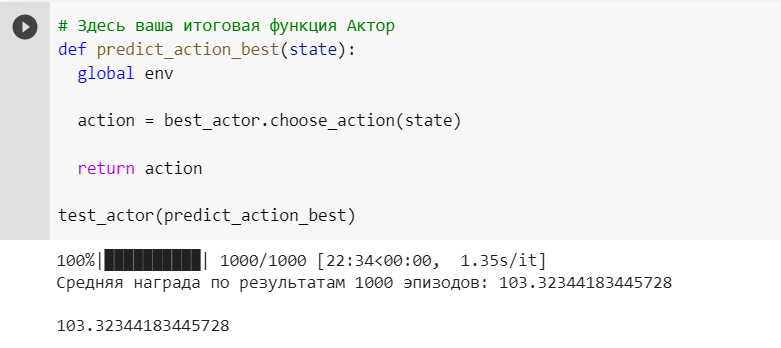